# Auto-ARIMA to Forecast Daily MW Usage 30 Days in Ahead

### **Results**

| Model  | Test MAE    | Test MAPE (%) |
|--------|-------------|---------------|
| ARIMA  | 13,992.8    | 10.4          |
| Naive  | 17,829.4    | 13.3          |


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from tqdm import tqdm

## Data Loading and Pre-Processing

**Source**: [Kaggle](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

*"PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.*

*The hourly power consumption data comes from PJM's website and are in megawatts (MW).*

*The regions have changed over the years so data may only appear for certain dates per region."*

In [2]:
df = pd.read_csv('PJMW_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.drop_duplicates('Datetime', inplace=True)
df.set_index('Datetime', inplace=True)
df = df.resample('24h').sum()[:-1] # removing the last day due to incomplete data
timeseries = df['PJMW_MW']

display(df.head(5000).describe().T)
display(df.head(5))

,count,mean,std,min,25%,50%,75%,max
PJMW_MW,5000.0,134434.6068,17595.843859,72433.0,121162.75,132522.5,146049.25,210008.0


,PJMW_MW
Datetime,
2002-04-01,121237.0
2002-04-02,127450.0
2002-04-03,127822.0
2002-04-04,136099.0
2002-04-05,136467.0


In [3]:
# Split
ts = timeseries.to_numpy().reshape(-1, 1) 
train = ts[:5000]
test = ts[5000:]

# Scale
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
ts = scaler.transform(ts)

## EDA

#### ADF Test

ADF Statistic: -7.154172
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


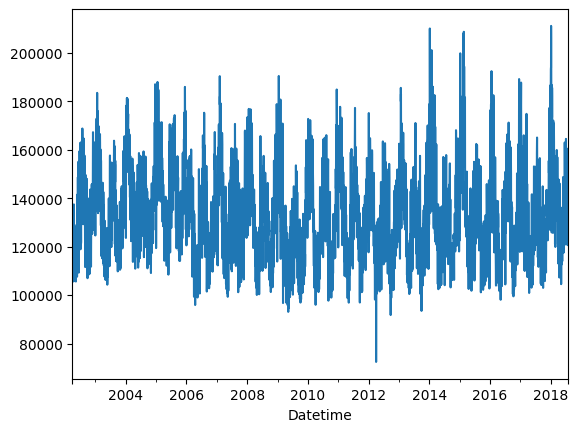

In [4]:
result = adfuller(timeseries[:5000])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

timeseries.plot()
plt.show()


#### ACF and PACF Graphs

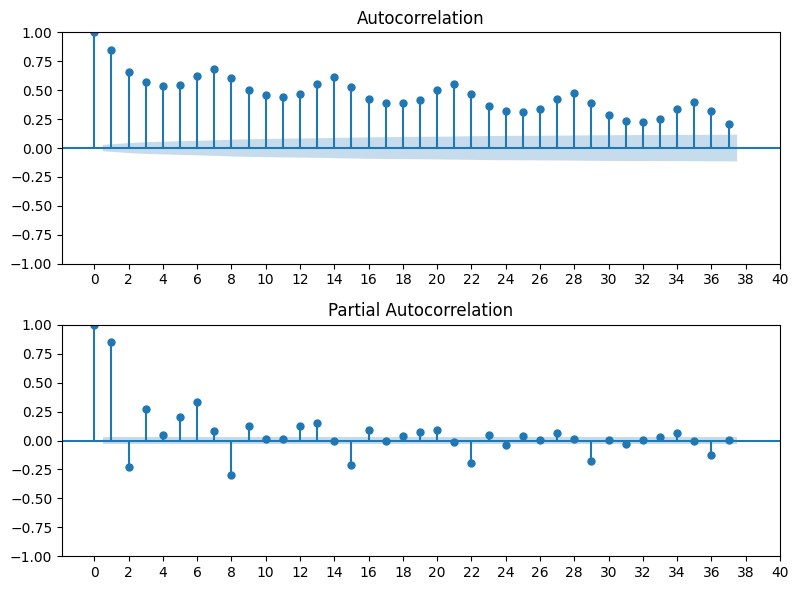

In [5]:
plt.figure(figsize=(8, 6))  

# Plot ACF on subplot 1
plt.subplot(211)
plot_acf(train, ax=plt.gca(), title='Autocorrelation')
plt.xticks(range(0, 41, 2))  

# Plot PACF on subplot 2
plt.subplot(212)
plot_pacf(train, ax=plt.gca(), title='Partial Autocorrelation')
plt.xticks(range(0, 41, 2))  

plt.tight_layout()  
plt.show()


## Auto-ARIMA

In [6]:
model = pm.auto_arima(train[:-30], 
                      stationary=True,
                      seasonal=True,
                      m=7,
                      max_p=3,
                      max_d=1,
                      max_q=3,
                      max_order=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=6.86 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=14124.309, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=6253.902, Time=0.99 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=8480.602, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14122.337, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=7725.216, Time=0.22 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=5717.351, Time=2.60 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=8.45 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.56 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=10613.477, Time=1.07 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=5363.874, Time=2.80 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=5878.631, Time=1.59 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=8.15 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.40 sec
 ARIMA(3,0,0)(2,0,0)[7] intercept   : AIC=5280.360, Tim

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 4970
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2633.182
Date:                           Fri, 10 May 2024   AIC                           5278.364
Time:                                   15:13:06   BIC                           5317.431
Sample:                                        0   HQIC                          5292.060
                                          - 4970                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0432      0.012     90.078      0.000       1.021       1.066
ar.L2         -0.3960      0.016    -24.107      0.000      -0.428      -0.364
ar.L3          0.1330      0.012     10.872      0.000       0.109       0.157
ar.S.L7        0.3486      0.011     30.979      0.000       0.327       0.371
ar.S.L14       0.3110      0.012     25.592      0.000       0.287       0.335
sigma2         0.1688      0.003     65.707      0.000       0.164       0.174
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               598.72
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA Test Predictions

In [8]:
history = train.copy()
predictions = []

for t in tqdm(test):
    prediction = model.predict(n_periods=30)[-1]
    predictions.append(prediction)    
    history = np.append(history, t)
    obs = history[:-30][-1]
    model.update(obs)

100%|██████████| 968/968 [11:43<00:00,  1.38it/s]


## Evaluation

In [9]:
y_test = scaler.inverse_transform(test).reshape(-1)
y_naive = history[:-30][-len(test):].reshape(-1, 1)
y_naive = scaler.inverse_transform(y_naive).reshape(-1)
y_pred = np.array(predictions).reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred).reshape(-1)

arima_mae = np.mean(np.abs(y_pred - y_test))
arima_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100

naive_mae = np.mean(np.abs(y_naive - y_test))
naive_mape = np.mean(np.abs((y_naive - y_test) / y_test)) * 100

summary_df = pd.DataFrame({
    'Model': ['ARIMA', 'Naive'],
    'MAE': [arima_mae, naive_mae],
    'MAPE (%)': [arima_mape, naive_mape]
})

display(summary_df)

,Model,MAE,MAPE (%)
0,ARIMA,13992.766408,10.429607
1,Naive,17829.363636,13.295322


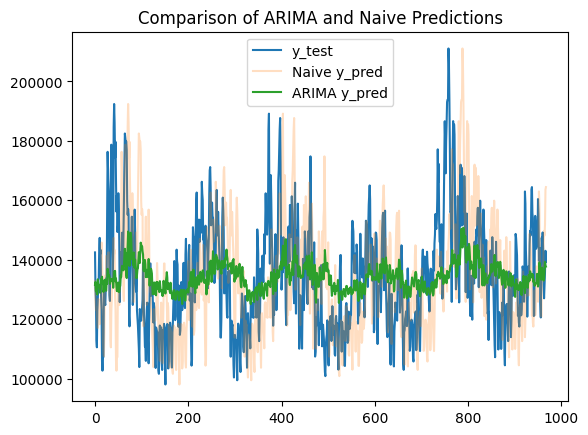

In [10]:
fig, ax = plt.subplots()
ax.plot(y_test, label='y_test')
ax.plot(y_naive, label='Naive y_pred', linestyle='-', alpha=0.25)
ax.plot(y_pred, label='ARIMA y_pred', linestyle='-')
ax.legend()
plt.title('Comparison of ARIMA and Naive Predictions')
plt.show()

## Citation

RobikSCube. (n.d.). *Hourly Energy Consumption*. Kaggle. Retrieved May 10, 2024, from [https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)